### Importing Data and Packages

In [240]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from itertools import combinations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.stats.stats import pearsonr
from statsmodels.stats.weightstats import ztest

In [22]:
#New York listings
df = pd.read_csv('listings-2.csv')

/Users/OwenPeng/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Cleaning Data and Removing Outliers

In [23]:
#turning price values into integers
df.price = df.price.map(lambda x: x.replace("$", ''))
df.price = df.price.map(lambda x: x.replace(",", ''))
df.price = df.price.map(lambda x: float(x))

In [24]:
#turning superhost data into 0's and 1's
df['host_is_superhost'] = df.host_is_superhost.apply(lambda x: 0 if x  == 'f' else 1)

### Borough Specific Data

In [19]:
Brooklyn = df[df['neighbourhood_group_cleansed']=='Brooklyn']
Manhattan = df[df['neighbourhood_group_cleansed']=='Manhattan']
Bronx = df[df['neighbourhood_group_cleansed']=='Bronx']
Queens = df[df['neighbourhood_group_cleansed']=='Queens']
Staten_Island = df[df['neighbourhood_group_cleansed']=='Staten Island']

In [14]:
Br_Price = Brooklyn['reviews_per_month'].values.reshape(-1, 1)
M_Price = Manhattan['reviews_per_month'].values.reshape(-1, 1)
Bx_Price = Bronx['reviews_per_month'].values.reshape(-1, 1)
Q_Price = Queens['reviews_per_month'].values.reshape(-1, 1)
SI_Price = Staten_Island['reviews_per_month'].values.reshape(-1, 1)

imp = SimpleImputer(missing_values=np.nan, strategy='median')
Br_Imp = imp.fit_transform(Br_Price)
M_Imp = imp.fit_transform(M_Price)
Bx_Imp = imp.fit_transform(Bx_Price)
Q_Imp = imp.fit_transform(Q_Price)
SI_Imp = imp.fit_transform(SI_Price)

In [11]:
#Scaling for Visual Purposes only
df=df[df['bedrooms']<=15]
df=df[df['price']<=200]
df=df[df['reviews_per_month']<=5]
df=df[df['review_scores_rating']>=70]

### Exploratory Data Analysis of Dependent Variables

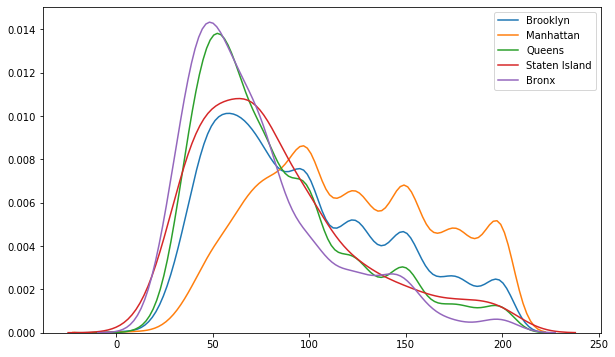

In [15]:
#Price Data
plt.figure(figsize=(10,6))
sns.kdeplot(Brooklyn['price'], label= 'Brooklyn')
sns.kdeplot(Manhattan['price'], label= 'Manhattan')
sns.kdeplot(Queens['price'], label= 'Queens')
sns.kdeplot(Staten_Island['price'], label= 'Staten Island')
sns.kdeplot(Bronx['price'], label="Bronx")

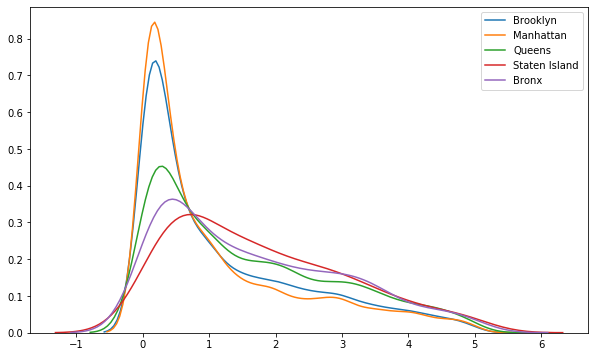

In [16]:
#Distribution plot of reviews per month
plt.figure(figsize=(10,6))
sns.kdeplot(Brooklyn['reviews_per_month'], label= 'Brooklyn')
sns.kdeplot(Manhattan['reviews_per_month'], label= 'Manhattan')
sns.kdeplot(Queens['reviews_per_month'], label= 'Queens')
sns.kdeplot(Staten_Island['reviews_per_month'], label= 'Staten Island')
sns.kdeplot(Bronx['reviews_per_month'], label="Bronx")

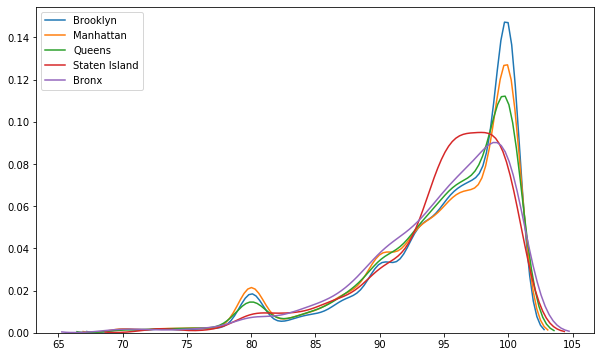

In [17]:
#Review Scores by Borough
plt.figure(figsize=(10,6))
sns.kdeplot(Brooklyn['review_scores_rating'], label= 'Brooklyn')
sns.kdeplot(Manhattan['review_scores_rating'], label= 'Manhattan')
sns.kdeplot(Queens['review_scores_rating'], label= 'Queens')
sns.kdeplot(Staten_Island['review_scores_rating'], label= 'Staten Island')
sns.kdeplot(Bronx['review_scores_rating'], label="Bronx")

### Calculating Profitability

In [34]:
#using reviews per month and some estimationns we could calculate occupancy rate and from there revenue could be found
reviews_rate = 0.4
avg_stay_length = 6.2
df['profit'] = (df['price']*df['reviews_per_month']*avg_stay_length)/reviews_rate

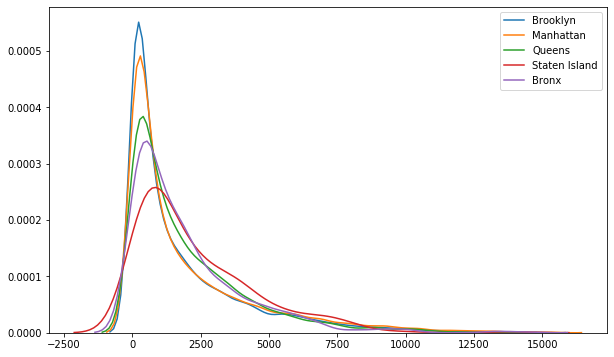

In [21]:
plt.figure(figsize=(10,6))
sns.kdeplot(Brooklyn['profit'], label= 'Brooklyn')
sns.kdeplot(Manhattan['profit'], label= 'Manhattan')
sns.kdeplot(Queens['profit'], label= 'Queens')
sns.kdeplot(Staten_Island['profit'], label= 'Staten Island')
sns.kdeplot(Bronx['profit'], label="Bronx")

### Contributions to Airbnb Profitability

#### Cleaning Categorical Variables

In [25]:
df = df[df['property_type'].isin(['Apartment','House', 'Townhouse', 'Condominium','Loft', 'Guest_suite', 'Boutique_hotel','Other']) ]

In [26]:
df.room_type = df.room_type.map(lambda x: x.replace(" ","_"))
df.room_type = df.room_type.map(lambda x: x.replace("/","_"))

In [27]:
df.bed_type = df.bed_type.map(lambda x: x.replace(" ","_"))
df.bed_type = df.bed_type.map(lambda x: x.replace("-","_"))

In [28]:
df.neighbourhood_group_cleansed = df.neighbourhood_group_cleansed.map(lambda x: x.replace(" ","_"))

#### Getting Dummy Variables

In [29]:
prop_dum = pd.get_dummies(df['property_type'], drop_first=True)

In [30]:
room_dum = pd.get_dummies(df['room_type'], drop_first=True)

In [31]:
bed_dum = pd.get_dummies(df['bed_type'], drop_first=True)

In [32]:
bor_dum = pd.get_dummies(df['neighbourhood_group_cleansed'],prefix = 'borough', drop_first=True)

#### Segmenting Relevent Categorical Variables

In [35]:
NY_cont = df[['host_listings_count','accommodates','bathrooms','bedrooms',
 'beds','price', 'availability_365', 'minimum_minimum_nights', 'maximum_minimum_nights',
 'minimum_maximum_nights', 'maximum_maximum_nights','minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm', 'review_scores_rating', 'review_scores_accuracy',
 'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
 'review_scores_location','review_scores_value','reviews_per_month', 'profit' ]]

In [36]:
df_c = pd.concat([NY_cont, prop_dum, room_dum, bed_dum, bor_dum], axis=1)

#### Running the Regression

In [45]:
outcome = 'profit'
covariants = ['profit', 'price', 'reviews_per_month']
x_cols = list(df_c.columns)
x_cols = [i for i in x_cols if i not in covariants] 

In [46]:
#regression fitting with all variables, will need to remove all nonsignificant variables
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_c.dropna()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     232.0
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        09:31:42   Log-Likelihood:            -3.7688e+05
No. Observations:               37593   AIC:                         7.538e+05
Df Residuals:                   37558   BIC:                         7.541e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                   -9183.6334    716.171    -12.823      0.000   -1.06e+04   -7779.920
host_listings_count            -4.7512      0.564     -8.430      0.000      -5.856      -3.647
accommodates                  893.5409     26.982     33.117      0.000     840.656     946.425
bathrooms                     194.1012     77.362      2.509      0.012      42.470     345.733
bedrooms                      374.7665     55.955      6.698      0.000     265.094     484.439
beds                           78.0336     39.955      1.953      0.051      -0.279     156.346
availability_365                5.4995      0.225     24.485      0.000       5.059       5.940
minimum_minimum_nights        -23.9175      3.227     -7.411      0.000     -30.243     -17.592
maximum_minimum_nights          7.7548      7.552      1.027      0.305      -7.048      22.557
minimum_maximum_nights         -4.8089      1.458     -3.298      0.001      -7.667      -1.951
maximum_maximum_nights          2.6173      7.101      0.369      0.712     -11.301      16.535
minimum_nights_avg_ntm         -9.1780      9.277     -0.989      0.322     -27.360       9.004
maximum_nights_avg_ntm          2.1917      7.978      0.275      0.784     -13.446      17.829
review_scores_rating          -17.5633      6.771     -2.594      0.009     -30.834      -4.292
review_scores_accuracy         74.1477     55.898      1.326      0.185     -35.413     183.708
review_scores_cleanliness     442.8113     39.164     11.306      0.000     366.048     519.575
review_scores_checkin         -99.7673     55.573     -1.795      0.073    -208.692       9.158
review_scores_communication    82.2319     59.071      1.392      0.164     -33.549     198.013
review_scores_location        476.2970     45.143     10.551      0.000     387.815     564.779
review_scores_value          -104.7709     52.105     -2.011      0.044    -206.899      -2.643
Condominium                   817.2444    158.667      5.151      0.000     506.253    1128.236
House                        -328.3343    109.115     -3.009      0.003    -542.202    -114.467
Loft                          546.2792    163.247      3.346      0.001     226.311     866.247
Other                       -1927.7509    674.825     -2.857      0.004   -3250.426    -605.076
Townhouse                     979.3035    151.464      6.466      0.000     682.430    1276.177
Private_room                 -148.8546     69.950     -2.128      0.033    -285.959     -11.750
Shared_room                  -754.2044    201.484     -3.743      0.000   -1149.119    -359.290
Couch                         876.0416    931.832      0.940      0.347    -950.375    2702.458
Futon                         703.0353    622.881      1.129      0.259    -517.828    1923.898
Pull_out_So

#### Refining the Model

In [51]:
### removing variables with nonsignificant p-values
outcome = 'profit'
remove = ['profit', 'price', 'reviews_per_month','maximum_minimum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
         'review_scores_accuracy','review_scores_communication', 'Couch', 'Futon', 'Pull_out_Sofa', 'borough_Brooklyn']
x_cols = list(df_c.columns)
x_cols = [i for i in x_cols if i not in remove] 

In [52]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_c.dropna()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     315.2
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        09:38:59   Log-Likelihood:            -3.7688e+05
No. Observations:               37593   AIC:                         7.538e+05
Df Residuals:                   37567   BIC:                         7.540e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -8237.6545    516.598    -15.946      0.000   -9250.200   -7225.109
host_listings_count          -4.7252      0.530     -8.913      0.000      -5.764      -3.686
accommodates                891.9394     26.960     33.083      0.000     839.096     944.783
bathrooms                   194.8929     77.224      2.524      0.012      43.533     346.253
bedrooms                    376.6199     55.917      6.735      0.000     267.021     486.218
beds                         78.2963     39.941      1.960      0.050       0.011     156.582
availability_365              5.4742      0.224     24.442      0.000       5.035       5.913
minimum_minimum_nights      -25.3442      1.567    -16.178      0.000     -28.415     -22.274
minimum_maximum_nights       -4.6592      1.091     -4.270      0.000      -6.798      -2.520
maximum_maximum_nights        4.6592      1.091      4.270      0.000       2.520       6.798
review_scores_rating        -12.2850      6.278     -1.957      0.050     -24.589       0.019
review_scores_cleanliness   447.1038     38.766     11.533      0.000     371.122     523.086
review_scores_checkin       -53.3299     49.291     -1.082      0.279    -149.941      43.281
review_scores_location      489.8254     44.777     10.939      0.000     402.061     577.590
review_scores_value         -86.2924     50.887     -1.696      0.090    -186.031      13.447
Condominium                 805.5712    158.578      5.080      0.000     494.755    1116.388
House                      -342.7362    108.539     -3.158      0.002    -555.477    -129.996
Loft                        544.8610    163.221      3.338      0.001     224.943     864.779
Other                     -1921.9907    674.299     -2.850      0.004   -3243.635    -600.346
Townhouse                   974.8307    151.387      6.439      0.000     678.109    1271.553
Private_room               -156.0417     69.856     -2.234      0.026    -292.960     -19.123
Shared_room                -772.2511    200.539     -3.851      0.000   -1165.312    -379.190
Real_Bed                    514.1166    230.849      2.227      0.026      61.646     966.588
borough_Manhattan          1265.7894     63.975     19.786      0.000    1140.397    1391.182
borough_Queens              274.7562     93.664      2.933      0.003      91.173     458.340
borough_Staten_Island      -898.4706    328.716     -2.733      0.006   -1542.762    -254.179
==============================================================================
Omnibus:                   103103.108   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      11108931493.610
Skew:                          34.052   Prob(JB):                         0.00
Kurtosis:                    2665.234   C

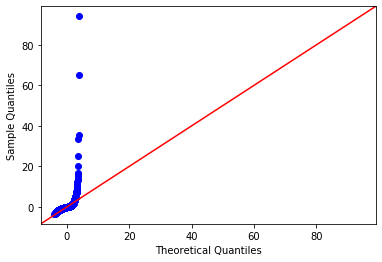

In [53]:
# Graphing Residuals indicates non-normally distributed residuals, should log transform profit data
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

### Rerunning the Regression with Transformed Data

In [80]:
#apply log transform to profit
df_c['profit_norm'] = (df_c['profit']+0.0000001).apply(np.log)

In [81]:
outcome = 'profit_norm'
remove = ['profit', 'price', 'reviews_per_month','maximum_minimum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
         'review_scores_accuracy','review_scores_communication', 'Couch', 'Futon', 'Pull_out_Sofa', 'borough_Brooklyn',
         'profit_norm']
x_cols = list(df_c.columns)
x_cols = [i for i in x_cols if i not in remove] 

In [82]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_c.dropna()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            profit_norm   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     477.6
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:30:46   Log-Likelihood:                -68100.
No. Observations:               37593   AIC:                         1.363e+05
Df Residuals:                   37567   BIC:                         1.365e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.9096      0.140     13.646      0.000       1.635       2.184
host_listings_count          -0.0018      0.000    -12.248      0.000      -0.002      -0.001
accommodates                  0.2369      0.007     32.441      0.000       0.223       0.251
bathrooms                    -0.1542      0.021     -7.370      0.000      -0.195      -0.113
bedrooms                     -0.0341      0.015     -2.250      0.024      -0.064      -0.004
beds                          0.0117      0.011      1.080      0.280      -0.010       0.033
availability_365              0.0031   6.07e-05     50.565      0.000       0.003       0.003
minimum_minimum_nights       -0.0119      0.000    -28.152      0.000      -0.013      -0.011
minimum_maximum_nights       -0.0010      0.000     -3.454      0.001      -0.002      -0.000
maximum_maximum_nights        0.0010      0.000      3.454      0.001       0.000       0.002
review_scores_rating         -0.0128      0.002     -7.553      0.000      -0.016      -0.010
review_scores_cleanliness     0.2447      0.011     23.302      0.000       0.224       0.265
review_scores_checkin         0.0762      0.013      5.709      0.000       0.050       0.102
review_scores_location        0.2209      0.012     18.209      0.000       0.197       0.245
review_scores_value          -0.0245      0.014     -1.778      0.075      -0.052       0.003
Condominium                   0.4374      0.043     10.181      0.000       0.353       0.522
House                         0.2476      0.029      8.423      0.000       0.190       0.305
Loft                          0.3670      0.044      8.299      0.000       0.280       0.454
Other                        -1.1681      0.183     -6.395      0.000      -1.526      -0.810
Townhouse                     0.4411      0.041     10.755      0.000       0.361       0.521
Private_room                 -0.2789      0.019    -14.738      0.000      -0.316      -0.242
Shared_room                  -0.5308      0.054     -9.771      0.000      -0.637      -0.424
Real_Bed                      0.4980      0.063      7.963      0.000       0.375       0.621
borough_Manhattan             0.3256      0.017     18.787      0.000       0.292       0.360
borough_Queens                0.1783      0.025      7.028      0.000       0.129       0.228
borough_Staten_Island        -0.0293      0.089     -0.329      0.742      -0.204       0.145
==============================================================================
Omnibus:                    19055.427   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           829243.097
Skew:                          -1.744   Prob(JB):                         0.00
Kurtosis:                      25.743   C

In [84]:
## refining the model by removing insignificant variables
outcome = 'profit_norm'
remove = ['profit', 'price', 'reviews_per_month','maximum_minimum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
         'review_scores_accuracy','review_scores_communication', 'Couch', 'Futon', 'Pull_out_Sofa', 'borough_Brooklyn',
         'profit_norm', 'host_listings_count','beds', 'borough_Staten_Island', 'minimum_maximum_nights', 'maximum_maximum_nights' ]
x_cols = list(df_c.columns)
x_cols = [i for i in x_cols if i not in remove]

In [85]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_c.dropna()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            profit_norm   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     586.5
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        10:35:39   Log-Likelihood:                -68181.
No. Observations:               37593   AIC:                         1.364e+05
Df Residuals:                   37572   BIC:                         1.366e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.8701      0.140     13.341      0.000       1.595       2.145
accommodates                  0.2422      0.006     38.010      0.000       0.230       0.255
bathrooms                    -0.1592      0.021     -7.636      0.000      -0.200      -0.118
bedrooms                     -0.0219      0.015     -1.504      0.133      -0.050       0.007
availability_365              0.0030   6.02e-05     49.434      0.000       0.003       0.003
minimum_minimum_nights       -0.0123      0.000    -28.919      0.000      -0.013      -0.011
review_scores_rating         -0.0137      0.002     -8.041      0.000      -0.017      -0.010
review_scores_cleanliness     0.2431      0.011     23.108      0.000       0.223       0.264
review_scores_checkin         0.0805      0.013      6.020      0.000       0.054       0.107
review_scores_location        0.2202      0.012     18.114      0.000       0.196       0.244
review_scores_value          -0.0141      0.014     -1.021      0.307      -0.041       0.013
Condominium                   0.4401      0.043     10.224      0.000       0.356       0.524
House                         0.2504      0.029      8.596      0.000       0.193       0.308
Loft                          0.3745      0.044      8.459      0.000       0.288       0.461
Other                        -1.1687      0.183     -6.385      0.000      -1.527      -0.810
Townhouse                     0.4387      0.041     10.685      0.000       0.358       0.519
Private_room                 -0.2657      0.019    -14.046      0.000      -0.303      -0.229
Shared_room                  -0.5062      0.054     -9.372      0.000      -0.612      -0.400
Real_Bed                      0.4912      0.063      7.842      0.000       0.368       0.614
borough_Manhattan             0.3107      0.017     17.981      0.000       0.277       0.345
borough_Queens                0.1775      0.025      7.016      0.000       0.128       0.227
==============================================================================
Omnibus:                    18916.863   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           815197.544
Skew:                          -1.727   Prob(JB):                         0.00
Kurtosis:                      25.550   Cond. No.                     4.46e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [123]:
### further removing values
outcome = 'profit_norm'
remove = ['profit', 'price', 'reviews_per_month','maximum_minimum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
         'review_scores_accuracy','review_scores_communication', 'Couch', 'Futon', 'Pull_out_Sofa', 'borough_Brooklyn',
         'profit_norm', 'host_listings_count','beds', 'borough_Staten_Island', 'minimum_maximum_nights', 'maximum_maximum_nights', 
         'bedrooms', 'review_scores_value','borough_Manhattan', 'borough_Queens' ]
x_cols = list(df_c.columns)
x_cols = [i for i in x_cols if i not in remove]

In [141]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_c.dropna()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            profit_norm   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     705.3
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        11:31:54   Log-Likelihood:                -68352.
No. Observations:               37593   AIC:                         1.367e+05
Df Residuals:                   37576   BIC:                         1.369e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.0209      0.140     14.389      0.000       1.746       2.296
accommodates                  0.2333      0.005     45.487      0.000       0.223       0.243
bathrooms                    -0.1778      0.020     -8.756      0.000      -0.218      -0.138
availability_365              0.0030   6.01e-05     50.139      0.000       0.003       0.003
minimum_minimum_nights       -0.0120      0.000    -28.190      0.000      -0.013      -0.011
review_scores_rating         -0.0160      0.002    -10.597      0.000      -0.019      -0.013
review_scores_cleanliness     0.2416      0.010     23.171      0.000       0.221       0.262
review_scores_checkin         0.0648      0.013      4.859      0.000       0.039       0.091
review_scores_location        0.2527      0.012     21.374      0.000       0.230       0.276
Condominium                   0.4470      0.043     10.342      0.000       0.362       0.532
House                         0.1855      0.028      6.653      0.000       0.131       0.240
Loft                          0.3065      0.044      6.922      0.000       0.220       0.393
Other                        -1.1555      0.184     -6.285      0.000      -1.516      -0.795
Townhouse                     0.3689      0.041      9.004      0.000       0.289       0.449
Private_room                 -0.3010      0.019    -16.140      0.000      -0.338      -0.264
Shared_room                  -0.5255      0.054     -9.705      0.000      -0.632      -0.419
Real_Bed                      0.4707      0.063      7.484      0.000       0.347       0.594
==============================================================================
Omnibus:                    18743.502   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           799118.863
Skew:                          -1.707   Prob(JB):                         0.00
Kurtosis:                      25.328   Cond. No.                     4.45e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

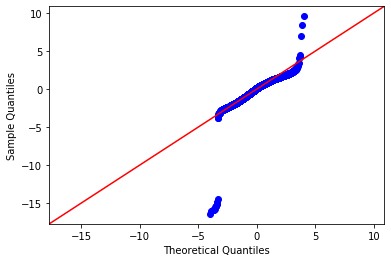

In [88]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

### Testing Model on Los Angeles Data

In [89]:
dfs = pd.read_csv('listings-3.csv')

/Users/OwenPeng/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [101]:
dfs.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,958,https://www.airbnb.com/rooms/958,20191204162709,2019-12-04,"Bright, Modern Garden Unit - 1BR/1B",New update: the house next door is under const...,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,none,*Quiet cul de sac in friendly neighborhood *St...,...,f,f,moderate,f,f,1,1,0,0,1.79
1,3850,https://www.airbnb.com/rooms/3850,20191204162709,2019-12-04,Charming room for two,Your own private room plus access to a shared ...,This room can fit two people. Nobody else will...,Your own private room plus access to a shared ...,none,"This is a quiet, safe neighborhood on a substa...",...,f,f,strict_14_with_grace_period,f,f,3,0,3,0,1.38
2,5858,https://www.airbnb.com/rooms/5858,20191204162709,2019-12-05,Creative Sanctuary,NaN,We live in a large Victorian house on a quiet ...,We live in a large Victorian house on a quiet ...,none,I love how our neighborhood feels quiet but is...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.86
3,7918,https://www.airbnb.com/rooms/7918,20191204162709,2019-12-04,A Friendly Room - UCSF/USF - San Francisco,Nice and good public transportation. 7 minute...,"Settle down, S.F. resident, student, hospital,...",Nice and good public transportation. 7 minute...,none,"Shopping old town, restaurants, McDonald, Whol...",...,f,f,strict_14_with_grace_period,f,f,9,0,9,0,0.14
4,8142,https://www.airbnb.com/rooms/8142,20191204162709,2019-12-04,Friendly Room Apt. Style -UCSF/USF - San Franc...,Nice and good public transportation. 7 minute...,"Settle down, S.F. resident, student, hospital,...",Nice and good public transportation. 7 minute...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,9,0,9,0,0.13


### Apply Same Data Cleaning Processes

In [102]:
dfs.price = dfs.price.map(lambda x: x.replace("$", ''))
dfs.price = dfs.price.map(lambda x: x.replace(",", ''))
dfs.price = dfs.price.map(lambda x: float(x))
dfs['host_is_superhost'] = dfs.host_is_superhost.apply(lambda x: 0 if x  == 'f' else 1)

In [105]:
dfs['property_type'].value_counts()

Apartment             3466
House                 2375
Condominium            910
Guest suite            592
Boutique hotel         338
Hotel                  145
Townhouse              142
Loft                   132
Serviced apartment     110
Hostel                  77
Aparthotel              66
Guesthouse              45
Bed and breakfast       33
Other                   23
Resort                  18
Cottage                 17
Bungalow                15
Castle                   6
Villa                    6
Tiny house               3
Boat                     3
Cabin                    3
Camper/RV                2
In-law                   2
Earth house              2
Hut                      1
Dome house               1
Name: property_type, dtype: int64

In [116]:
dfs.room_type = dfs.room_type.map(lambda x: x.replace(" ","_"))
dfs.room_type = dfs.room_type.map(lambda x: x.replace("/","_"))
dfs.bed_type = dfs.bed_type.map(lambda x: x.replace(" ","_"))
dfs.bed_type = dfs.bed_type.map(lambda x: x.replace("-","_"))
dfs.property_type = dfs.property_type.map(lambda x: x.replace(" ", "_"))
dfs = dfs[dfs['property_type'].isin(['Apartment','House', 'Townhouse', 'Condominium','Loft', 'Guest_suite', 'Boutique_hotel','Other','Hotel', 'Serviced apartment']) ]

/Users/OwenPeng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [117]:
sfprop_dum = pd.get_dummies(dfs['property_type'], drop_first=True)
sfroom_dum = pd.get_dummies(dfs['room_type'], drop_first=True)
sfbed_dum = pd.get_dummies(dfs['bed_type'], drop_first=True)

In [232]:
#Review Rate is guessed, avg_stay is from internet
reviews_rate = 0.4
avg_stay_length = 5.5
dfs['profit'] = (dfs['price']*dfs['reviews_per_month']*avg_stay_length)/reviews_rate

In [233]:
SF_cont = dfs[['host_listings_count','accommodates','bathrooms','bedrooms',
 'beds','price', 'availability_365', 'minimum_minimum_nights', 'maximum_minimum_nights',
 'minimum_maximum_nights', 'maximum_maximum_nights','minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm', 'review_scores_rating', 'review_scores_accuracy',
 'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
 'review_scores_location','review_scores_value','reviews_per_month', 'profit' ]]

In [234]:
dfs_c = pd.concat([SF_cont, sfprop_dum, sfroom_dum, sfbed_dum], axis=1)

In [235]:
dfs_c['profit_norm'] = (dfs_c['profit']+0.0000001).apply(np.log)

### Feed Independent SF variables into NY Profit Model

In [206]:
sf_pred = list(model.predict(dfs_c))

In [207]:
model.predict(dfs_c).describe()

count    5.502000e+03
mean    -2.109340e+02
std      1.617651e+04
min     -1.199893e+06
25%      6.684195e+00
50%      7.148000e+00
75%      7.617950e+00
max      1.056281e+01
dtype: float64

In [208]:
sf_pred.sort()

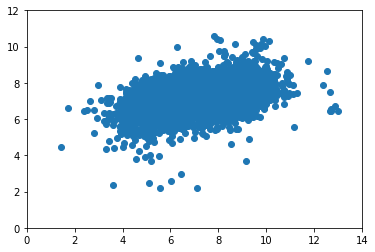

In [212]:
plt.ylim(0,12)
plt.xlim(0,14)
plt.scatter(dfs_c['profit_norm'],model.predict(dfs_c) )

In [210]:
mean_squared_error(dfs_c['profit_norm'].fillna(dfs_c['profit_norm'].mean()),model.predict(dfs_c).fillna(model.predict(dfs_c).mean()))

200171872.52620807

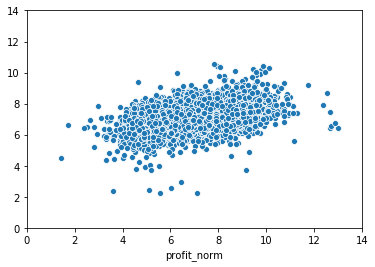

In [237]:
plt.ylim(0,14)
plt.xlim(0,14)
sns.scatterplot(dfs_c['profit_norm'],model.predict(dfs_c))

In [238]:
#first number is correlation coefficient and second is the p-value, neither are very siginificant
pearsonr(dfs_c['profit_norm'].fillna(dfs_c['profit_norm'].mean()),model.predict(dfs_c).fillna(model.predict(dfs_c).mean()))

(0.01916709566946816, 0.10406500753395806)

In [242]:
#2 sample z test indicates that these values are different
ztest(dfs_c['profit_norm'].fillna(dfs_c['profit_norm'].mean()),model.predict(dfs_c).fillna(model.predict(dfs_c).mean()))

(1.3091450041791743, 0.19048523714364074)

In [253]:
(dfs_c['profit_norm'] - model.predict(dfs_c)).describe()

count    5.502000e+03
mean     2.183968e+02
std      1.617648e+04
min     -2.305509e+01
25%     -7.230058e-01
50%      4.697302e-01
75%      1.403588e+00
max      1.199898e+06
dtype: float64